In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import umap.plot

import SEACells
import h5py
import collections
import scipy.sparse as sp_sparse
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata

In [2]:
dataset_dir = '../../data/'
save_dir = '../../data/NGJ/'
dataset = "NGJ/NGJ_experiment_2_filtered_feature_bc_matrix.h5"
dataset_name = "NGJ"
switch_dataset = "switch_genelist.csv"
gene_length_dataset = "gene_len_2.csv"

# Read switches

In [3]:
switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
# drop first column
switch_df = switch_df.drop(switch_df.columns[0], axis=1)

# switch df to dict
switch_dict = {}
for row in switch_df.index:
	switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Reference Matrix

In [72]:
adata = sc.read_10x_h5(dataset_dir + dataset)
adata

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1905 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [73]:
# make var names unique
adata.var_names_make_unique()

In [ ]:
adata.X = csr_matrix(adata.X)

In [74]:
raw_ad = sc.AnnData(adata.X)
raw_ad.obs_names, raw_ad.var_names = adata.obs_names, adata.var_names
adata.raw = raw_ad

In [75]:
# calculate total counts per sample
adata.obs['total_counts'] = adata.X.sum(axis=1)

In [76]:
# load gene length data
gene_length = pd.read_csv(dataset_dir + gene_length_dataset).T
gene_length.columns = ['gene_length']
gene_length = gene_length.drop(gene_length.index[0])
gene_length.head()

,gene_length
ENSG00000243485,1556
ENSG00000237613,1528
ENSG00000186092,6167
ENSG00000238009,44429
ENSG00000239945,1555


In [77]:
# drop genes in adata that are not in gene_length
gene_length = gene_length[gene_length.index.isin(adata.var['gene_ids'])]
adata = adata[:, adata.var['gene_ids'].isin(gene_length.index)]

# add gene length to adata
adata.var['gene_length'] = gene_length.loc[adata.var['gene_ids']].values

/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_35543/3098787622.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_length'] = gene_length.loc[adata.var['gene_ids']].values


In [78]:
# Calculate RPKM
adata.X = adata.X / adata.var['gene_length'].values / adata.obs['total_counts'].values[:, None] * 1e9

In [43]:
# # save rpkm as csv
# rpkm = pd.DataFrame(adata.X.toarray().T, index=adata.var_names, columns=adata.obs_names)
# rpkm.to_csv(save_dir + 'rpkm.csv')

# Clustering pipeline

## Create anndata for genes in JS

In [79]:
REPRESENT = "gene"

In [81]:
# calculate reference genes

rab7a = adata[:, adata.var_names.isin(['RAB7A'])].X.toarray() + 1
gapdh = adata[:, adata.var_names.isin(['GAPDH'])].X.toarray() + 1
actp = adata[:, adata.var_names.isin(['ACTB'])].X.toarray() + 1

ref_norm = (rab7a * gapdh * actp) ** (1/3)
ref_norm.min(), ref_norm.max()

(1.0, 130.45545004819158)

In [83]:
adata.obs['ref_norm'] = ref_norm

In [84]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
adata.X = adata.X / adata.obs['ref_norm'].values[:, None]


In [85]:
# take log2 of RPKM+1
sc.pp.log1p(adata, base=2)

# compute highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3660, subset=False) # n_top_genes = 36601 * 0.1

In [86]:
adata.X[adata.X.nonzero()] = adata.X[adata.X.nonzero()] + 10

In [111]:
adata = adata[:, adata.var['highly_variable']]

In [120]:
# save adata as tsv
pd.DataFrame(adata.X.toarray().T, columns=adata.obs_names, index=adata.var_names).to_csv(save_dir + "js_gene.tsv", sep='\t')

In [117]:
adata_processed = adata
adata_processed

View of AnnData object with n_obs × n_vars = 1905 × 3660
    obs: 'total_counts', 'ref_norm', 'SEACell'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_length', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'SEACell_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [118]:
PCA_ncomps = 1000

## Create anndata for switches in JS

In [467]:
REPRESENT = "switch"

In [468]:
# calculate reference genes
rab7a = rpkm.loc['RAB7A'].to_numpy()
gapdh = rpkm.loc['GAPDH'].to_numpy()
actp = rpkm.loc['ACTB'].to_numpy()

In [469]:
ref_norm = np.multiply(rab7a, gapdh, actp) ** (1/3)
ref_norm = np.log2(ref_norm)
ref_norm.min(), ref_norm.max()

(0.0, 4.574091725798939)

In [470]:
# take log2 of RPKM+1
rpkm_log2 = np.log2(rpkm)

In [471]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
js = pd.DataFrame(np.where(rpkm_log2 == 0, rpkm_log2, 10 + rpkm_log2 - ref_norm), columns=rpkm_log2.columns, index = rpkm_log2.index)

In [472]:
# compare genes in switches with genes in rpkm
switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
# change to set
switch_genes = set(switch_genes)
rpkm_genes = set(rpkm.index)

# find overlapping genes
overlapping_genes = switch_genes.intersection(rpkm_genes)
print(len(switch_genes), len(rpkm_genes), len(overlapping_genes))

5079 32582 4988


In [473]:
# filter non-overlapping genes from switches
for switch in switch_dict.keys():
	switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

In [474]:
# aggregate rpkm columns using switch_dict
js_switch = pd.DataFrame(columns=js.columns, index=switch_dict.keys())
for i in switch_dict.keys():
	js_switch.loc[i] = np.mean(js.loc[switch_dict[i]].values, axis=0)

In [475]:
# saving js switch data
js_switch.to_csv(save_dir + "js_switch.csv", sep='\t')

In [476]:
# convert data to AnnData
adata_processed = anndata.AnnData(csr_matrix(js_switch.T.values, dtype=np.float32))
adata_processed.X

<1905x489 sparse matrix of type '<class 'numpy.float32'>'
	with 492717 stored elements in Compressed Sparse Row format>

In [477]:
adata_processed.obs_names = js_switch.columns
adata_processed.var_names = js_switch.index

In [478]:
PCA_ncomps = 90

## SEACells Clustering and UMAP

In [119]:
sc.tl.pca(adata_processed, n_comps=PCA_ncomps)

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [121]:
cumsum = np.cumsum(adata_processed.uns['pca']['variance_ratio'])
print("#", np.count_nonzero(cumsum < 0.95), "PC's capture 95% of variance")

# 1000 PC's capture 95% of variance


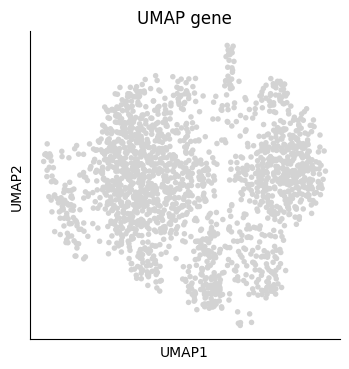

In [122]:
sc.pp.neighbors(adata_processed)
sc.tl.umap(adata_processed)
sc.pl.umap(adata_processed, save=f'_{dataset_name}_{REPRESENT}.png', title=f'UMAP {REPRESENT}')

### Run SEACells

In [123]:
## Core parameters
n_SEACells = 15
build_kernel_on = 'X_pca'

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells !!not sure how to tune

In [124]:
model = SEACells.core.SEACells(adata_processed,
                  build_kernel_on=build_kernel_on,
                  n_SEACells=n_SEACells,
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [125]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1905 [00:00<?, ?it/s]

Constructing CSR matrix...


In [126]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 159.71it/s]

Selecting 6 cells from greedy initialization.


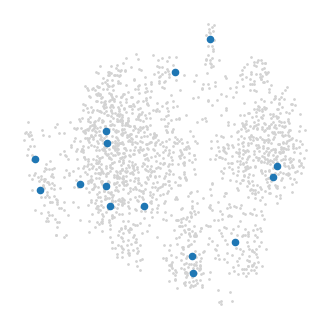

In [127]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata_processed, model)

In [128]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00049
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 17 iterations.


### Assessing results

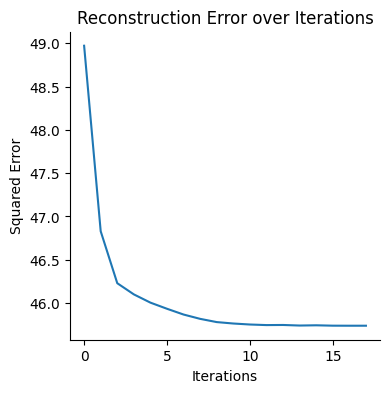

In [129]:
# Check for convergence
model.plot_convergence()

In [130]:
model.get_hard_assignments().head()

,SEACell
index,
AAACCCAAGCAGCACA-1,SEACell-3
AAACGAAAGACCGTTT-1,SEACell-3
AAACGAAAGGGCGAAG-1,SEACell-11
AAACGCTTCCTCGCAT-1,SEACell-1
AAAGAACAGGGAGGAC-1,SEACell-9


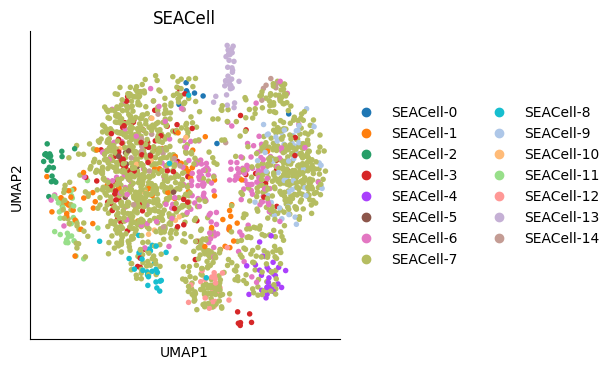

In [131]:
sc.pl.umap(adata_processed, color='SEACell', save=f'_SEACells_{dataset_name}_{REPRESENT}.png')

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


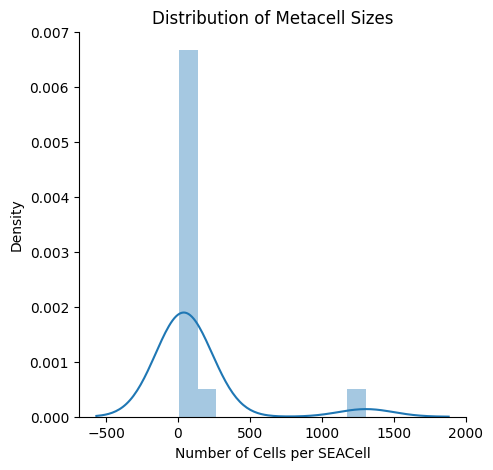

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:131: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame(label_df.groupby('SEACell').count().iloc[:, 0]).rename(columns={'index':'size'})


,size
SEACell,
SEACell-0,8
SEACell-1,62
SEACell-2,20
SEACell-3,99
SEACell-4,28
SEACell-5,8
SEACell-6,177
SEACell-7,1307
SEACell-8,29


In [132]:
SEACells.plot.plot_SEACell_sizes(adata_processed, bins=10)

# Saving Results

In [133]:
model.get_hard_assignments().to_csv(save_dir + f'SEACell_assignments_{REPRESENT}.csv', sep='\t')